Real analysis

## imports

In [6]:
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import plotly.express as px
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)
from haversine import haversine
from IPython.display import HTML
import plotly.graph_objects as go

In [7]:
import rpy2
import rpy2.robjects as ro 
from rpy2.robjects.vectors import FloatVector 
from rpy2.robjects.packages import importr

## load data and clean it

`-` load

In [8]:
df= pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/earthquakes-23k.csv')
df

Date  Latitude  Longitude  Magnitude
0      01/02/1965   19.2460   145.6160        6.0
1      01/04/1965    1.8630   127.3520        5.8
2      01/05/1965  -20.5790  -173.9720        6.2
3      01/08/1965  -59.0760   -23.5570        5.8
4      01/09/1965   11.9380   126.4270        5.8
...           ...       ...        ...        ...
23407  12/28/2016   38.3917  -118.8941        5.6
23408  12/28/2016   38.3777  -118.8957        5.5
23409  12/28/2016   36.9179   140.4262        5.9
23410  12/29/2016   -9.0283   118.6639        6.3
23411  12/30/2016   37.3973   141.4103        5.5

[23412 rows x 4 columns]

In [9]:
df_korea= pd.read_csv('earthquake_korea2.csv').iloc[:,[1,2,5,6]].rename(columns={'규모':'Magnitude'})

https://www.weather.go.kr/w/eqk-vol/search/korea.do?schOption=&xls=0&startTm=2012-01-02&endTm=2022-06-17&startSize=2&endSize=&startLat=&endLat=&startLon=&endLon=&lat=&lon=&dist=&keyword=&dpType=m

In [10]:
df_global= pd.concat([pd.read_csv('00_05.csv'),pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv'),pd.read_csv('15_20.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

https://www.usgs.gov/programs/earthquake-hazards/lists-maps-and-statistics

`-` cleaning

In [11]:
df.Date[df.Date == '1975-02-23T02:58:41.000Z']

3378    1975-02-23T02:58:41.000Z
Name: Date, dtype: object

In [12]:
df.iloc[3378,0] = '02/03/1975'

In [13]:
df.Date[df.Date == '1985-04-28T02:53:41.530Z']

7512    1985-04-28T02:53:41.530Z
Name: Date, dtype: object

In [14]:
df.iloc[7512,0] = '04/28/1985'

In [15]:
df.Date[df.Date == '2011-03-13T02:23:34.520Z']

20650    2011-03-13T02:23:34.520Z
Name: Date, dtype: object

In [16]:
df.iloc[20650,0] = '03/13/2011'

In [17]:
df= df.assign(Year=list(map(lambda x: x.split('/')[-1], df.Date))).iloc[:,1:]
df

Latitude  Longitude  Magnitude  Year
0       19.2460   145.6160        6.0  1965
1        1.8630   127.3520        5.8  1965
2      -20.5790  -173.9720        6.2  1965
3      -59.0760   -23.5570        5.8  1965
4       11.9380   126.4270        5.8  1965
...         ...        ...        ...   ...
23407   38.3917  -118.8941        5.6  2016
23408   38.3777  -118.8957        5.5  2016
23409   36.9179   140.4262        5.9  2016
23410   -9.0283   118.6639        6.3  2016
23411   37.3973   141.4103        5.5  2016

[23412 rows x 4 columns]

In [18]:
df.Year = df.Year.astype(np.float64)

In [19]:
df_korea = df_korea.assign(Year=list(map(lambda x: x.split('/')[0], df_korea.발생시각))).iloc[:,1:]
df_korea = df_korea.assign(Latitude=list(map(lambda x: x.split(' ')[0], df_korea.위도))).iloc[:,[0,2,3,4]]
df_korea = df_korea.assign(Longitude=list(map(lambda x: x.split(' ')[0], df_korea.경도))).iloc[:,[0,2,3,4]]

In [20]:
df_global = df_global.assign(Year=list(map(lambda x: x.split('-')[0], df_global.time))).iloc[:,1:]

In [21]:
df_korea.Year = df_korea.Year.astype(np.float64)
df_korea.Latitude = df_korea.Latitude.astype(np.float64)
df_korea.Longitude = df_korea.Longitude.astype(np.float64)
df_global.Year = df_global.Year.astype(np.float64)

## define class

In [22]:
class MooYaHo:
    def __init__(self,df):
        self.df = df 
        self.f = df.Magnitude.to_numpy()
        self.year = df.Year.to_numpy()
        self.lat = df.Latitude.to_numpy()
        self.long = df.Longitude.to_numpy()
        self.n = len(self.f)
        
        self.theta= None
    def get_distance(self):
        self.D = np.zeros([self.n,self.n])
        locations = np.stack([self.lat, self.long],axis=1)
        for i in tqdm.tqdm(range(self.n)):
            for j in range(i,self.n): 
                self.D[i,j]=haversine(locations[i],locations[j])
        self.D = self.D+self.D.T
    def get_weightmatrix(self,theta=1,beta=0.5,kappa=4000):
        self.theta = theta
        dist = np.where(self.D<kappa,self.D,0)
        self.W = np.exp(-(dist/self.theta)**2)

    def _eigen(self):
        d= self.W.sum(axis=1)
        D= np.diag(d)
        self.L = np.diag(1/np.sqrt(d)) @ (D-self.W) @ np.diag(1/np.sqrt(d))
        self.lamb, self.Psi = np.linalg.eigh(self.L)
        self.Lamb = np.diag(self.lamb)        
    def fit(self,m):
        self._eigen()
        self.fhat = self.Psi[:,0:m]@self.Psi[:,0:m].T@self.f
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        plt.plot(self.f,'.')
        plt.plot(self.fhat,'x')
        
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.4,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 0.6
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.5
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visf(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visfhat(self):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='MagnitudeHat', 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))
    def visres(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z=[0] * len(self.df), 
                        radius=5,
                        center=dict(lat=37, lon=160), 
                        zoom=1.5,
                        height=900,
                        opacity = 0.7,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.7
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [23]:
class MooYaHo2(MooYaHo): # ebayesthresh 기능추가
    def fit2(self,ref=0.5): # fit with ebayesthresh
        self._eigen()
        self.fbar = self.Psi.T @ self.f # fbar := graph fourier transform of f
        self.power = self.fbar**2 
        ebayesthresh = importr('EbayesThresh').ebayesthresh
        self.power_threshed=np.array(ebayesthresh(FloatVector(self.fbar**2)))
        self.fbar_threshed = np.where(self.power_threshed>0,self.fbar,0)
        self.fhat = self.Psi@self.fbar_threshed
        self.df = self.df.assign(MagnitudeHat = self.fhat)
        self.df = self.df.assign(Residual = self.df.Magnitude- self.df.MagnitudeHat)
        self.con = np.where(self.df.Residual>0.7,1,0)
        #plt.plot(self.f,'.')
        #plt.plot(self.fhat,'x')

#         fig, axs = plt.subplots(2,2,figsize=(16,10))

#         axs[0,0].plot(self.f,'b')
#         axs[0,0].set_title('Magnitude')
#         axs[0,0].set_ylim([4.5,9])

#         axs[0,1].plot(self.fhat,'k')
#         axs[0,1].set_title('MagnitudeHat')
#         axs[0,1].set_ylim([4.5,9])

#         axs[1,0].plot(self.con,'r*')
#         axs[1,0].set_title('Residual square')

#         axs[1,1].plot(self.f,'b')
#         axs[1,1].plot(self.fhat,'k')
#         axs[1,1].plot(self.con,'r*')
#         axs[1,1].set_title('Graph')
#         axs[1,1].set_ylim([4.5,9])

#         plt.tight_layout()
#         plt.show()

In [24]:
class MooYaHo3(MooYaHo2):
    def vis(self,MagThresh=7,ResThresh=1):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=5,
                        center=dict(lat=37, lon=126), 
                        zoom=5.7,
                        height=900,
                        opacity = 0.3,
                        mapbox_style="stamen-terrain")
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'red',
                      opacity = 0.5
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= 8,
                      marker_color= 'blue',
                      opacity = 0.5
                      )
        return HTML(fig.to_html(include_mathjax=False, config=dict({'scrollZoom':False})))

In [25]:
       ebayesthresh = importr('EbayesThresh').ebayesthresh

## analysis_df_global(2010~2015)

`-` make instance for analysis

In [32]:
moo_global=MooYaHo2(df_global.query("2010 <= Year < 2015"))

`-` get distance 

In [33]:
moo_global.get_distance()

100%|██████████| 10762/10762 [05:32<00:00, 32.36it/s] 


In [34]:
moo_global.D[moo_global.D>0].mean()

8746.68756693945

(array([10857854., 11686138., 15883516., 16913862., 14592080., 12938904.,
        11847394.,  9636694.,  9649504.,  1799146.]),
 array([8.97930163e-02, 2.00141141e+03, 4.00273303e+03, 6.00405465e+03,
        8.00537626e+03, 1.00066979e+04, 1.20080195e+04, 1.40093411e+04,
        1.60106627e+04, 1.80119844e+04, 2.00133060e+04]),
 <BarContainer object of 10 artists>)

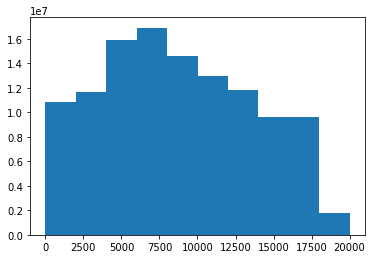

In [35]:
plt.hist(moo_global.D[moo_global.D>0])

`-` weight matrix

In [36]:
moo_global.get_weightmatrix(theta=(8810.865423093777),kappa=2500) 

`-` fit

In [37]:
moo_global.fit2()

In [38]:
moo_global.df.sort_values("Residual",ascending=False).iloc[:40,:]

Latitude  Longitude  Magnitude    Year  MagnitudeHat  Residual
30311   38.2970   142.3730        9.1  2011.0      7.625067  1.474933
11094  -36.1220   -72.8980        8.8  2010.0      7.638469  1.161531
32803  -36.1220   -72.8980        8.8  2010.0      7.789231  1.010769
32436  -36.2170   -73.2570        6.7  2010.0      5.841501  0.858499
26564   14.1290   -92.1640        6.5  2012.0      5.653542  0.846458
27513    0.8020    92.4630        8.2  2012.0      7.368113  0.831887
30347   38.4350   142.8420        7.3  2011.0      6.490603  0.809397
30296   36.2810   141.1110        7.9  2011.0      7.156346  0.743654
10292    7.8810    91.9360        7.5  2010.0      6.766319  0.733681
9193    26.9010   143.6980        7.4  2010.0      6.667897  0.732103
32554  -36.6650   -73.3740        6.6  2010.0      5.873441  0.726559
30301   38.9690   143.3700        6.7  2011.0      5.984234  0.715766
32001    7.8810    91.9360        7.5  2010.0      6.793936  0.706064
31229   -3.4870   100.0820        7.8  2010.0      7.100594  0.699406
28229   37.3650   141.3680        6.1  2011.0      5.403952  0.696048
9283   -56.4120   -25.7410        6.3  2010.0      5.607381  0.692619
9520    -3.4870   100.0820        7.8  2010.0      7.111591  0.688409
30827  -19.7020   167.9470        7.3  2010.0      6.615744  0.684256
30295   36.0230   142.2690        6.6  2011.0      5.917664  0.682336
27456    2.5810    90.2690        6.2  2012.0      5.521275  0.678725
30017   37.5940   142.6480        6.5  2011.0      5.828617  0.671383
10135  -22.1460   -68.2160        6.3  2010.0      5.631982  0.668018
24958  -60.2738   -46.4011        7.7  2013.0      7.041204  0.658796
10783  -34.2900   -71.8910        6.9  2010.0      6.241810  0.658190
29019  -29.3370  -177.0510        6.0  2011.0      5.347355  0.652645
32492  -34.2900   -71.8910        6.9  2010.0      6.250075  0.649925
30902   26.9010   143.6980        7.4  2010.0      6.758872  0.641128
28931   52.8810   108.4400        5.3  2011.0      4.661692  0.638308
29004   38.0340   143.2640        7.0  2011.0      6.368649  0.631351
30992  -56.4120   -25.7410        6.3  2010.0      5.680727  0.619273
30893   27.2030   143.4550        5.3  2010.0      4.681926  0.618074
9665    -4.9630   133.7600        7.0  2010.0      6.382904  0.617096
29640   38.2760   141.5880        7.1  2011.0      6.485066  0.614934
26354   55.2280  -134.8591        7.5  2013.0      6.890518  0.609482
27527    2.3270    93.0630        8.6  2012.0      7.992761  0.607239
25452  -60.8570   -25.0700        7.3  2013.0      6.693727  0.606273
29536  -10.3750   161.2000        6.8  2011.0      6.197847  0.602153
26468   37.8900   143.9490        7.3  2012.0      6.698942  0.601058
32231  -15.2710  -173.2190        6.1  2010.0      5.502608  0.597392
26234  -11.1830   164.8820        7.1  2013.0      6.507029  0.592971

(2010~2014 시도)
- 21번째 Ouest Department, Haiti 아이티 지진 2010년 진도 7.0
- 24번째 Puchuncavi, Valparaíso, Chile 칠레 지진 2014년 진도 6.4
- 28번째 Baoxing County, Yaan, Sichuan, China 중국 쓰촨성 지진 2013년 진도 6.6

(2010~2015 시도_결과 좋지 않음?!)
- 23번째 2010년 West New Britain Province, Papua New Guinea 진도 7.3
- 24번째 2011년 Kuzawa Terayama, Tanagura, Higashishirakawa District, Fukushima 963-5671, Japan 진도 6.6
- 29번째 2015년 Kishim, Afghanistan 진도 7.5

`-` vis

In [39]:
#moo_global.visf()

In [40]:
#moo_global.visfhat()

In [41]:
#moo_global.visres()

In [42]:
#moo_global.vis(MagThresh=6.9,ResThresh=0.5)

___

## analysis_df_global(2015~2020)

`-` make instance for analysis

In [43]:
moo_global=MooYaHo2(df_global.query("2015 <= Year <= 2020"))

`-` get distance 

In [44]:
moo_global.get_distance()

100%|██████████| 11239/11239 [04:35<00:00, 40.84it/s] 


In [45]:
moo_global.D[moo_global.D>0].mean()

8814.318793468068

(array([10894274., 13618924., 16426520., 17583818., 16025000., 15684642.,
        13794372., 10946494.,  9072574.,  2254138.]),
 array([2.54728455e-02, 2.00123511e+03, 4.00244475e+03, 6.00365439e+03,
        8.00486402e+03, 1.00060737e+04, 1.20072833e+04, 1.40084929e+04,
        1.60097026e+04, 1.80109122e+04, 2.00121218e+04]),
 <BarContainer object of 10 artists>)

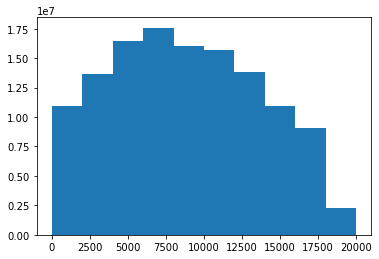

In [46]:
plt.hist(moo_global.D[moo_global.D>0])

`-` weight matrix

In [47]:
moo_global.get_weightmatrix(theta=(8814.318793468068),kappa=2500) 

`-` fit

In [48]:
moo_global.fit2()

In [49]:
moo_global.df.sort_values("Residual",ascending=False).iloc[:30,:]

Latitude  Longitude  Magnitude    Year  MagnitudeHat  Residual
21952  -31.5729   -71.6744        8.3  2015.0      7.294011  1.005989
36363  -21.9496   169.4266        7.5  2018.0      6.523828  0.976172
36993  -18.1125  -178.1530        8.2  2018.0      7.311720  0.888280
39932  -42.7373   173.0540        7.8  2016.0      6.951928  0.848072
36263   55.0999   164.6993        7.3  2018.0      6.470796  0.829204
35004  -30.1733  -177.8625        6.1  2019.0      5.285797  0.814203
41015   -4.9521    94.3299        7.8  2016.0      6.993888  0.806112
21719   -8.3381   124.8754        6.5  2015.0      5.698526  0.801474
33404   54.6020  -159.6258        7.6  2020.0      6.819466  0.780534
41735  -31.5729   -71.6744        8.3  2015.0      7.547595  0.752405
40113  -19.7819  -178.2443        6.9  2016.0      6.148672  0.751328
41695  -31.5173   -71.8040        6.7  2015.0      5.951922  0.748078
37927   56.0039  -149.1658        7.9  2018.0      7.170056  0.729944
36848  -18.4743   179.3502        7.9  2018.0      7.173844  0.726156
21945  -31.5622   -71.4262        7.0  2015.0      6.291422  0.708578
41502   -8.3381   124.8754        6.5  2015.0      5.812161  0.687839
33896  -33.2927  -177.8571        7.4  2020.0      6.715142  0.684858
22560   -5.4912   151.8715        6.0  2015.0      5.316904  0.683096
39584  -43.4064   -73.9413        7.6  2016.0      6.921775  0.678225
36777  -25.4150   178.1991        6.5  2018.0      5.833282  0.666718
35487  -30.6441  -178.0995        7.3  2019.0      6.638342  0.661658
39771  -10.6812   161.3273        7.8  2016.0      7.145371  0.654629
38827  -30.5156  -178.0563        6.0  2017.0      5.351325  0.648675
41963   52.3760  -169.4458        6.9  2015.0      6.256523  0.643477
22488   27.8087    86.0655        7.3  2015.0      6.662980  0.637020
21795  -54.4856  -135.7080        6.1  2015.0      5.468025  0.631975
22839  -10.7598   164.1216        6.1  2015.0      5.468139  0.631861
41423   38.6700    20.6000        6.5  2015.0      5.874436  0.625564
36101  -30.0404   -71.3815        6.7  2019.0      6.081398  0.618602
36602  -21.7427   169.5217        6.5  2018.0      5.882525  0.617475

바다 아닌 거
- 8번째 2016년 Rotherham, New Zealand 뉴질랜드 카이코우라 지진 진도 7.8
- 9번째 2015년 Langkuru Utara, Pureman, Alor Regency, East Nusa Tenggara, Indonesia 수마트라 진도 6.5
- 15번째 2018년 Hela Province, Papua New Guinea 파푸아뉴기니 진도 7.5
- 20번째 2015년 Kalinchok, Nepal 네팔 진도 7.3
- 26번째 2019년 Coquimbo, Chile 칠레 코킴보주 진도 6.7

`-` vis

In [50]:
#moo_global.vis(MagThresh=7,ResThresh=0.3)

---

In [ ]:
pd.read_html('https://en.wikipedia.org/wiki/Lists_of_21st-century_earthquakes',encoding='utf-8')[0].query('Magnitude<=7')# List of deadliest earthquakes

In [ ]:
pd.read_html('https://en.wikipedia.org/wiki/Lists_of_21st-century_earthquakes',encoding='utf-8')[3] # Deadliest earthquakes by year

---

In [52]:
class eachlocation(MooYaHo2):
    def haiti(self,MagThresh=7,ResThresh=1,adjzoom=5,adjmarkersize = 40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=18.4430, lon=-72.5710), 
                        zoom= adjzoom,
                        height=900,
                        opacity = 0.8,
                        mapbox_style="stamen-terrain",
                        range_color=[-3,3])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.4
                    )
                ))
        return fig 
    def lquique(self,MagThresh=7,ResThresh=1,adjzoom=5, adjmarkersize= 40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=-32.6953, lon=-71.4416), 
                        zoom=adjzoom,
                        height=900,
                        opacity = 0.8,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.8
                    )
                ))
        return fig 
    def sichuan(self,MagThresh=7,ResThresh=1,adjzoom=5,adjmarkersize=40):
        fig = px.density_mapbox(self.df, 
                        lat='Latitude', 
                        lon='Longitude', 
                        z='Magnitude', 
                        radius=15,
                        center=dict(lat=30.3080, lon=102.8880), 
                        zoom=adjzoom,
                        height=900,
                        opacity = 0.6,
                        mapbox_style="stamen-terrain",
                        range_color=[-7,7])
        fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
        fig.add_scattermapbox(lat = self.df.query('Magnitude > @MagThresh')['Latitude'],
                      lon = self.df.query('Magnitude > @MagThresh')['Longitude'],
                      text = self.df.query('Magnitude > @MagThresh')['Magnitude'],
                      marker_size= 5,
                      marker_color= 'blue',
                      opacity = 0.1
                      )
        fig.add_scattermapbox(lat = self.df.query('Residual**2 > @ResThresh')['Latitude'],
                      lon = self.df.query('Residual**2 > @ResThresh')['Longitude'],
                      text = self.df.query('Magnitude > @ResThresh')['Magnitude'],
                      marker_size= adjmarkersize,
                      marker_color= 'red',
                      opacity = 0.8
                      )
        fig.add_trace(go.Scattermapbox(
                    lat=self.df.query('Residual**2 > @ResThresh')['Latitude'],
                    lon=self.df.query('Residual**2 > @ResThresh')['Longitude'],
                    mode='markers',
                    marker=go.scattermapbox.Marker(
                        size=20,
                        color='rgb(255, 255, 255)',
                        opacity=0.8
                    )
                ))
        return fig 

In [53]:
each_location=eachlocation(df_global.query("2010 <= Year < 2015"))

`-` get distance 

In [54]:
each_location.get_distance()

100%|██████████| 12498/12498 [05:55<00:00, 35.16it/s] 


In [55]:
each_location.D[each_location.D>0].mean()

8810.865423093777

(array([14176290., 16005894., 21186674., 22331128., 19394182., 17548252.,
        16668048., 13316436., 12973260.,  2582550.]),
 array([8.97930163e-02, 2.00141141e+03, 4.00273303e+03, 6.00405465e+03,
        8.00537626e+03, 1.00066979e+04, 1.20080195e+04, 1.40093411e+04,
        1.60106627e+04, 1.80119844e+04, 2.00133060e+04]),
 <BarContainer object of 10 artists>)

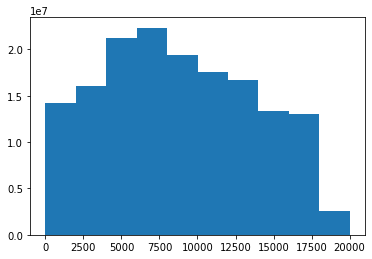

In [56]:
plt.hist(each_location.D[each_location.D>0])

`-` weight matrix

In [57]:
each_location.get_weightmatrix(theta=(8810.865423093777),kappa=2500) 

`-` fit

In [58]:
each_location.fit2()

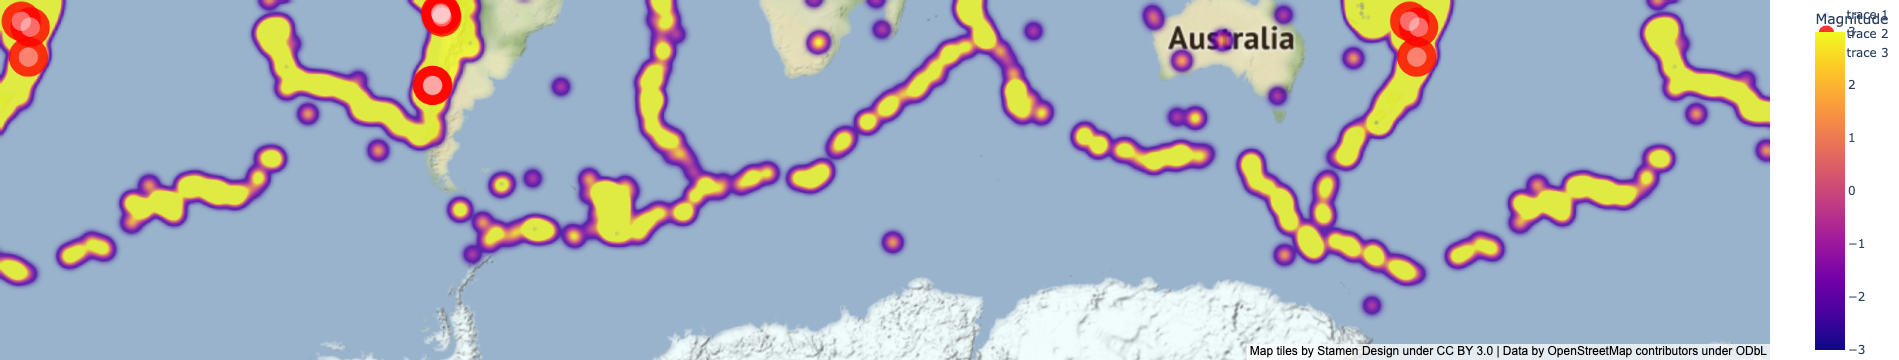

In [59]:
each_location.haiti(MagThresh=6.9,ResThresh=0.5)

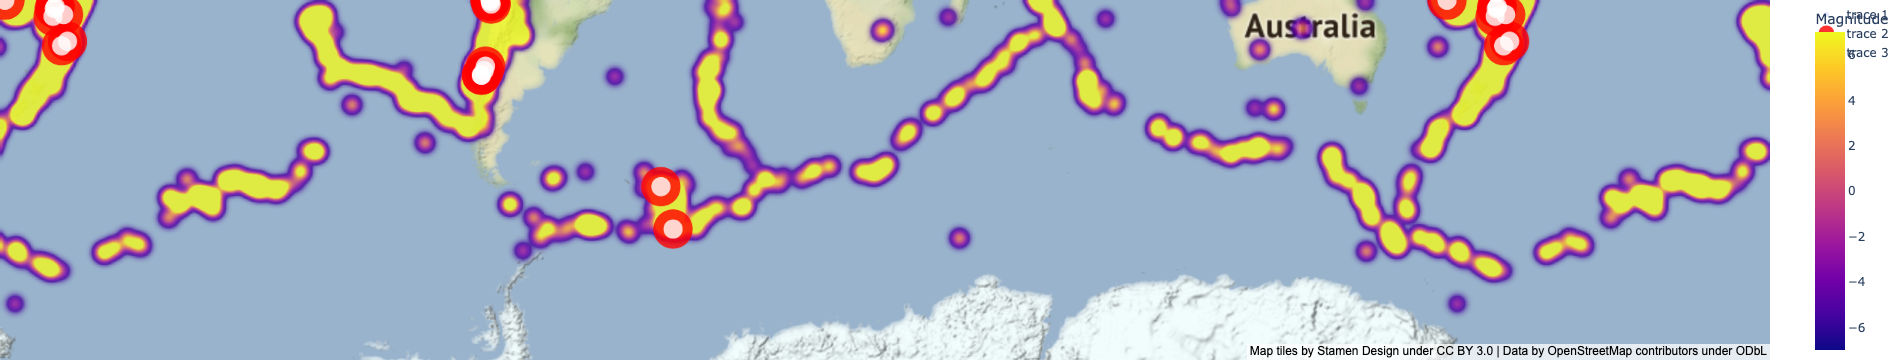

In [60]:
each_location.lquique(MagThresh=8,ResThresh=0.4,adjzoom=4.3)

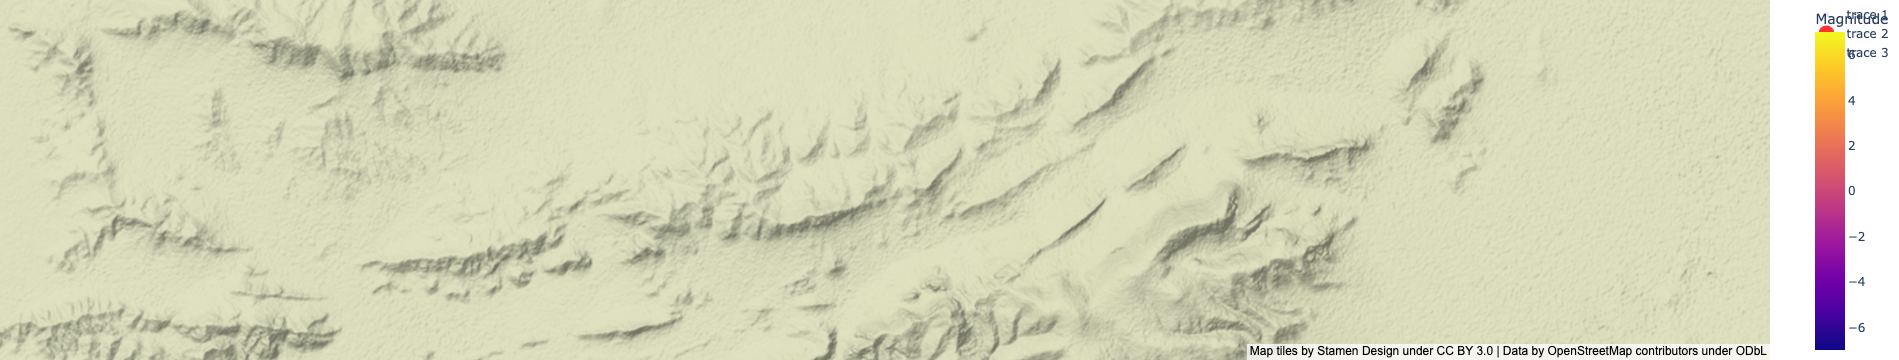

In [61]:
each_location.sichuan(MagThresh=6.5,ResThresh=0.4)

---

## 칠레 

In [62]:
df_chile_ex= pd.concat([pd.read_csv('05_10.csv'),pd.read_csv('10_15.csv')]).iloc[:,[0,1,2,4]].rename(columns={'latitude':'Latitude','longitude':'Longitude','mag':'Magnitude'}).reset_index().iloc[:,1:]

In [63]:
df_chile = df_chile_ex.assign(Year=list(map(lambda x: x.split('-')[0], df_chile_ex.time))).iloc[:,1:]

In [64]:
df_chile = df_chile.assign(Month=list(map(lambda x: x.split('-')[1], df_chile_ex.time)))

In [65]:
df_chile.Year = df_chile.Year.astype(np.float64)
df_chile.Month = df_chile.Month.astype(np.float64)

In [66]:
chile_location=eachlocation(df_chile.query("2010 <= Year < 2015"))

In [67]:
chile_location.get_distance()

100%|██████████| 12498/12498 [06:28<00:00, 32.19it/s] 


In [68]:
chile_location.get_weightmatrix(theta=(chile_location.D[chile_location.D>0].mean()),kappa=2500) 

In [69]:
chile_location.fit2()

아이티

In [70]:
chile_location.df.assign(Residual2 = chile_location.df.Residual**2).reset_index().iloc[2324:2330,:]

index  Latitude  Longitude  Magnitude    Year  Month  MagnitudeHat  \
2324   2324    18.463    -72.626        5.0  2010.0    1.0      5.105168   
2325   2325    18.387    -72.784        6.0  2010.0    1.0      5.703460   
2326   2326    18.443    -72.571        7.0  2010.0    1.0      6.659386   
2327   2327    -5.417    133.731        5.5  2010.0    1.0      5.604103   
2328   2328    15.437    -88.761        5.1  2010.0    1.0      4.964642   
2329   2329   -16.861   -174.228        5.3  2010.0    1.0      5.340902   

      Residual  Residual2  
2324 -0.105168   0.011060  
2325  0.296540   0.087936  
2326  0.340614   0.116018  
2327 -0.104103   0.010837  
2328  0.135358   0.018322  
2329 -0.040902   0.001673

칠레

In [71]:
chile_location.df.assign(Residual2 = chile_location.df.Residual**2).reset_index().query("-56.5 < Latitude & Latitude <-17.4 & -81.5 < Longitude & Longitude < -61.5 & Year == 2014 & Month == 8")

index  Latitude  Longitude  Magnitude    Year  Month  MagnitudeHat  \
2997  14603  -32.6953   -71.4416        6.4  2014.0    8.0      6.088353   
2999  14605  -20.1745   -69.0385        5.6  2014.0    8.0      5.553419   
3032  14638  -20.1580   -70.0230        5.3  2014.0    8.0      5.251934   
3046  14652  -23.9047   -66.7371        5.0  2014.0    8.0      5.210380   
3057  14663  -33.7770   -72.2030        5.2  2014.0    8.0      5.065422   

      Residual  Residual2  
2997  0.311647   0.097124  
2999  0.046581   0.002170  
3032  0.048066   0.002310  
3046 -0.210380   0.044260  
3057  0.134578   0.018111

중국

In [72]:
chile_location.df.assign(Residual2 = chile_location.df.Residual**2).reset_index().iloc[5136:5142,:]

index  Latitude  Longitude  Magnitude    Year  Month  MagnitudeHat  \
5136  16742    30.209    102.862        5.0  2013.0    4.0      4.943022   
5137  16743    30.308    102.888        6.6  2013.0    4.0      5.904218   
5138  16744    39.693    143.258        5.0  2013.0    4.0      5.118611   
5139  16745    49.965    157.652        6.1  2013.0    4.0      5.852776   
5140  16746   -11.976    121.632        5.8  2013.0    4.0      5.809708   
5141  16747   -14.966    166.857        5.2  2013.0    4.0      5.145590   

      Residual  Residual2  
5136  0.056978   0.003247  
5137  0.695782   0.484113  
5138 -0.118611   0.014068  
5139  0.247224   0.061120  
5140 -0.009708   0.000094  
5141  0.054410   0.002960